# Predictive Maintenance for Turbofan Engines
## Using NASA C-MAPSS Dataset (FD001)

**Project Goal:** Predict the Remaining Useful Life (RUL) of turbofan engines using LSTM neural networks.

**Dataset:** NASA Commercial Modular Aero-Propulsion System Simulation (C-MAPSS)

**Approach:**
- Time-series analysis using LSTM (Long Short-Term Memory) networks
- Sensor data preprocessing and feature engineering
- Piecewise RUL calculation to improve model performance
- Sequential modeling with 50-timestep windows

## 1. Import Required Libraries

We'll import all necessary libraries for:
- **Data manipulation:** pandas, numpy
- **Visualization:** matplotlib
- **Machine Learning:** scikit-learn for preprocessing
- **Deep Learning:** TensorFlow/Keras for LSTM model

In [50]:
# Data manipulation and numerical computing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Machine Learning - Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.20.0


## 2. Define Column Names

The NASA C-MAPSS dataset files have no headers. We need to manually define:
- **Index columns:** unit_nr (engine ID), time_cycles (operational cycle)
- **Setting columns:** 3 operational settings
- **Sensor columns:** 21 sensors (s_1 to s_21)

We'll also identify columns to drop that are constant or provide no useful information for FD001 dataset.

In [51]:
# Define column names for the dataset
index_cols = ['unit_nr', 'time_cycles']
setting_cols = ['setting_1', 'setting_2', 'setting_3']
sensor_cols = ['s_' + str(i) for i in range(1, 22)]  # s_1 to s_21

# Combine all columns
all_cols = index_cols + setting_cols + sensor_cols

# Columns to drop for FD001 (constant or useless features)
# These columns show no variance or don't contribute to RUL prediction
cols_to_drop = ['setting_1', 'setting_2', 'setting_3', 
                's_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']

print(f"Total columns: {len(all_cols)}")
print(f"Columns to drop: {len(cols_to_drop)}")
print(f"Features to use: {len(all_cols) - len(cols_to_drop) - 2}")  # -2 for index columns

Total columns: 26
Columns to drop: 10
Features to use: 14


## 3. Load Data

Loading three files:
1. **train_FD001.txt** - Training data with sensor readings
2. **test_FD001.txt** - Test data (engines run up to some point, not failure)
3. **RUL_FD001.txt** - Ground truth RUL values for test engines

All files are space-separated without headers.

In [52]:
# Load training data
train_df = pd.read_csv('CMAPSSData/train_FD001.txt', sep='\s+', header=None, names=all_cols)

# Load test data
test_df = pd.read_csv('CMAPSSData/test_FD001.txt', sep='\s+', header=None, names=all_cols)

# Load ground truth RUL values for test set
rul_df = pd.read_csv('CMAPSSData/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

# Display data shapes
print("Data loaded successfully!")
print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"RUL data shape: {rul_df.shape}")
print(f"\nNumber of engines in training set: {train_df['unit_nr'].nunique()}")
print(f"Number of engines in test set: {test_df['unit_nr'].nunique()}")

Data loaded successfully!
Train data shape: (20631, 26)
Test data shape: (13096, 26)
RUL data shape: (100, 1)

Number of engines in training set: 100
Number of engines in test set: 100


In [53]:
# Preview the training data
print("Training Data Sample:")
train_df.head(10)

Training Data Sample:


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,522.32,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,522.47,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,521.79,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,521.79,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694


## 4. Calculate RUL for Training Data

**RUL (Remaining Useful Life)** = Maximum cycles for that engine - Current cycle

**Piecewise RUL Strategy:**
- We clip RUL at 125 cycles
- **Reason:** Early in an engine's life, there's minimal degradation. Capping RUL prevents the model from learning noise during the "healthy" phase.
- This focuses the model on learning patterns that matter for prediction.

In [54]:
# Calculate the maximum time_cycles for each engine unit
max_cycles = train_df.groupby('unit_nr')['time_cycles'].max().reset_index()
max_cycles.columns = ['unit_nr', 'max_cycles']

# Merge with training data
train_df = train_df.merge(max_cycles, on='unit_nr', how='left')

# Calculate RUL: max_cycles - current_cycle
train_df['RUL'] = train_df['max_cycles'] - train_df['time_cycles']

# Drop the temporary max_cycles column
train_df.drop('max_cycles', axis=1, inplace=True)

# Apply piecewise RUL - clip at 125 cycles
train_df['RUL'] = train_df['RUL'].clip(upper=125)

# Display RUL statistics
print("RUL Statistics:")
print(train_df['RUL'].describe())
print(f"\nRUL range: {train_df['RUL'].min()} to {train_df['RUL'].max()}")

RUL Statistics:
count    20631.000000
mean        86.829286
std         41.673699
min          0.000000
25%         51.000000
50%        103.000000
75%        125.000000
max        125.000000
Name: RUL, dtype: float64

RUL range: 0 to 125


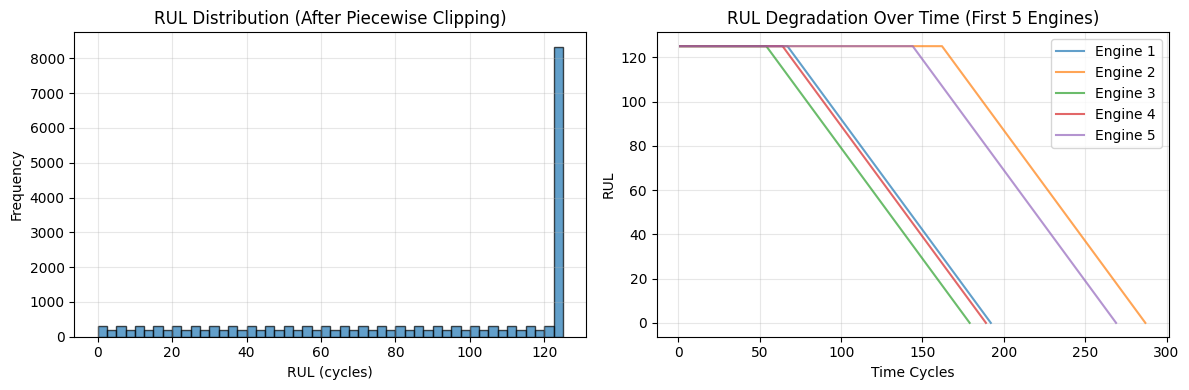

In [55]:
# Visualize RUL distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_df['RUL'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('RUL (cycles)')
plt.ylabel('Frequency')
plt.title('RUL Distribution (After Piecewise Clipping)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Show RUL progression for first 5 engines
for unit in range(1, 6):
    unit_data = train_df[train_df['unit_nr'] == unit]
    plt.plot(unit_data['time_cycles'], unit_data['RUL'], label=f'Engine {unit}', alpha=0.7)
plt.xlabel('Time Cycles')
plt.ylabel('RUL')
plt.title('RUL Degradation Over Time (First 5 Engines)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Feature Selection and Normalization

**Feature Selection:**
- Remove constant/uninformative columns
- Keep only sensors that vary and contribute to predictions

**Normalization:**
- Use MinMaxScaler to scale all features between 0 and 1
- This helps LSTM converge faster and prevents feature dominance

In [56]:
# Drop constant/useless columns from both train and test
train_df = train_df.drop(cols_to_drop, axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

# Identify feature columns (exclude index and target columns)
feature_cols = [col for col in train_df.columns if col not in ['unit_nr', 'time_cycles', 'RUL']]

print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")

# Initialize MinMaxScaler with explicit range (0, 1)
# STRICT SCALING: Fit ONLY on training data, then transform both
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scaler on training data and transform both train and test
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

print("\nFeatures normalized successfully!")
print(f"Feature value range: 0 to 1")

Number of features: 14
Features: ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

Features normalized successfully!
Feature value range: 0 to 1


In [57]:
# Verify normalization
print("Sample of normalized features:")
train_df[feature_cols].head()

Sample of normalized features:


,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502


## 6. Sequence Generation for LSTM

**Why Sequences?**
- LSTM networks require 3D input: [Samples, Time Steps, Features]
- We create sliding windows of 50 time steps
- Each window captures the temporal pattern of sensor degradation

**Training vs Test:**
- **Training:** Generate all possible sequences from each engine
- **Test:** Only use the LAST sequence from each engine (to match against ground truth RUL)

In [58]:
def gen_sequence(df, sequence_length, feature_cols):
    """
    Generate sequences from a single engine's data.
    
    Parameters:
    -----------
    df : DataFrame
        Data for a single engine unit
    sequence_length : int
        Number of time steps in each sequence
    feature_cols : list
        List of feature column names
        
    Returns:
    --------
    sequences : ndarray
        3D array of shape (num_sequences, sequence_length, num_features)
    targets : ndarray
        1D array of RUL targets
    """
    data_array = df[feature_cols].values
    num_elements = data_array.shape[0]
    
    sequences = []
    targets = []
    
    # Create sliding windows
    # We iterate up to num_elements - sequence_length + 1 to include the last possible sequence
    for start, stop in zip(range(0, num_elements - sequence_length + 1), 
                          range(sequence_length, num_elements + 1)):
        sequences.append(data_array[start:stop, :])
        # Target is the RUL at the current time step (end of the sequence)
        # We use stop-1 because stop is the exclusive upper bound of the slice
        targets.append(df['RUL'].iloc[stop-1])
    
    return np.array(sequences), np.array(targets)


def gen_sequence_by_unit(df, sequence_length, feature_cols):
    """
    Generate sequences for all engine units in the dataset.
    
    Parameters:
    -----------
    df : DataFrame
        Complete dataset with multiple engine units
    sequence_length : int
        Number of time steps in each sequence
    feature_cols : list
        List of feature column names
        
    Returns:
    --------
    X : ndarray
        All sequences concatenated
    y : ndarray
        All targets concatenated
    """
    X_list = []
    y_list = []
    
    # Process each engine unit separately
    for unit_id in df['unit_nr'].unique():
        unit_df = df[df['unit_nr'] == unit_id].reset_index(drop=True)
        
        # Only generate sequences if engine has enough data
        if len(unit_df) >= sequence_length:
            X_unit, y_unit = gen_sequence(unit_df, sequence_length, feature_cols)
            X_list.append(X_unit)
            y_list.append(y_unit)
    
    return np.concatenate(X_list), np.concatenate(y_list)


def gen_test_sequence(df, sequence_length, feature_cols):
    """
    Generate test sequences - only the LAST sequence from each engine.
    
    Parameters:
    -----------
    df : DataFrame
        Test dataset with multiple engine units
    sequence_length : int
        Number of time steps in each sequence
    feature_cols : list
        List of feature column names
        
    Returns:
    --------
    X : ndarray
        Last sequence from each engine
    """
    X_list = []
    
    # Process each engine unit
    for unit_id in df['unit_nr'].unique():
        unit_df = df[df['unit_nr'] == unit_id].reset_index(drop=True)
        
        if len(unit_df) >= sequence_length:
            # Take only the last sequence
            last_sequence = unit_df[feature_cols].values[-sequence_length:, :]
            X_list.append(last_sequence)
        else:
            # Pad with zeros if engine has fewer records than sequence_length
            padded_sequence = np.zeros((sequence_length, len(feature_cols)))
            padded_sequence[-len(unit_df):, :] = unit_df[feature_cols].values
            X_list.append(padded_sequence)
    
    return np.array(X_list)

print("Sequence generation functions defined!")

Sequence generation functions defined!


In [59]:
# Set sequence length (number of time steps to look back)
sequence_length = 50

print(f"Generating sequences with length = {sequence_length}...\n")

# Generate training sequences
X_train, y_train = gen_sequence_by_unit(train_df, sequence_length, feature_cols)

# Ensure RUL is clipped at 125 (Piecewise RUL) - Double check to prevent model collapse
y_train = np.clip(y_train, a_min=None, a_max=125)

print(f"Training sequences shape: {X_train.shape}")
print(f"Training targets shape: {y_train.shape}")
print(f"Total training samples: {X_train.shape[0]}")
print(f"Max RUL in training set: {y_train.max()}")

# Generate test sequences (only last sequence per engine)
X_test = gen_test_sequence(test_df, sequence_length, feature_cols)
y_test = rul_df['RUL'].values
print(f"\nTest sequences shape: {X_test.shape}")
print(f"Test targets shape: {y_test.shape}")
print(f"Total test samples (engines): {X_test.shape[0]}")

Generating sequences with length = 50...

Training sequences shape: (15731, 50, 14)
Training targets shape: (15731,)
Total training samples: 15731
Max RUL in training set: 125

Test sequences shape: (100, 50, 14)
Test targets shape: (100,)
Total test samples (engines): 100


## 7. Build Advanced LSTM Model

**Architecture Upgrade:**
To improve performance and prevent "flat line" predictions, we are using a more robust architecture:

1.  **Bidirectional LSTM (128 units):** Processes the sequence from start-to-end AND end-to-start. This captures the context of degradation much better.
2.  **Dropout (0.3):** Increased dropout rate to prevent overfitting and force the model to learn robust features.
3.  **Deep LSTM Layers:** Additional LSTM layers (64 and 32 units) to extract hierarchical features from the sensor data.
4.  **Dense Output (ReLU):** Uses ReLU activation to ensure the model never predicts negative Remaining Useful Life.

**Optimizer:** Adam with a lower learning rate (0.001) for stability.
**Loss Function:** Mean Squared Error (MSE).

In [ ]:
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Build "Pro" Model (Bidirectional = sees future & past context)
model = Sequential([
    Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.3),
    
    LSTM(units=64, return_sequences=True),
    Dropout(0.3),
    
    LSTM(units=32, return_sequences=False),
    Dropout(0.3),
    
    Dense(1, activation='relu') # ReLU ensures we never predict negative numbers
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("Model Architecture Upgrade:")
model.summary()

Model Architecture Upgrade:


c:\Users\rdxpt\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       146,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,057 (941.63 KB)

 Trainable params: 241,057 (941.63 KB)

 Non-trainable params: 0 (0.00 B)


Starting Smarter Training...
Epoch 1/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - loss: 5409.7754 - mae: 62.1800 - val_loss: 5210.0830 - val_mae: 61.5115 - learning_rate: 0.0010
Epoch 2/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 3946.2439 - mae: 52.3405 - val_loss: 3919.7363 - val_mae: 53.1878 - learning_rate: 0.0010
Epoch 3/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - loss: 3008.6948 - mae: 45.9621 - val_loss: 3048.6213 - val_mae: 47.3918 - learning_rate: 0.0010
Epoch 4/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 33s 75ms/step - loss: 2414.3835 - mae: 41.8052 - val_loss: 2489.1987 - val_mae: 43.5077 - learning_rate: 0.0010
Epoch 5/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - loss: 2075.5466 - mae: 39.4122 - val_loss: 2154.1340 - val_mae: 41.0420 - learning_rate: 0.0010
Epoch 6/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 1893.0266 - mae: 38.0164 - val_loss: 1967.3499 - val_mae: 39.5553 - learning_rate: 0.0010
Epoch 7/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 55s 125ms/s

## 8. Train the Model

**Advanced Training Strategy:**
- **Early Stopping:** Stops training if validation loss doesn't improve for 15 epochs (prevents overfitting).
- **Learning Rate Scheduler:** Reduces learning rate if the model gets stuck (helps convergence).
- **Epochs:** Set to 100, but Early Stopping will likely stop it earlier.
- **Batch Size:** 32 (smaller batches often lead to better generalization).

In [ ]:
# 2. Define Callbacks (The key to fixing the "Flat Line")
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,          # Wait longer before giving up
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,           # Cut learning rate in half if we get stuck
    patience=5, 
    min_lr=0.0001
)

# 3. Train with Smaller Batch Size
print("\nStarting Smarter Training...")
history = model.fit(
    X_train, y_train,
    epochs=100,           # Set high, let EarlyStopping decide when to stop
    batch_size=32,        # Small batch = more updates = model learns faster
    validation_split=0.1,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1,
    shuffle=True
)

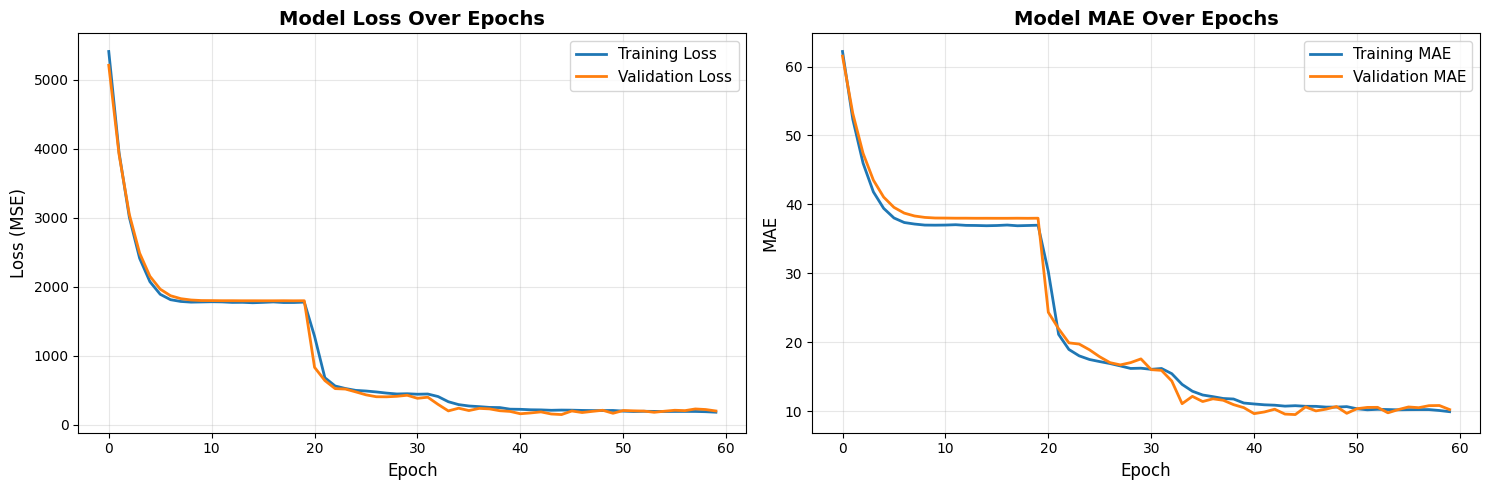

In [61]:
# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot training and validation MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Evaluate on Test Set

**Evaluation Strategy:**
1.  **Prediction:** Predict RUL for the LAST sequence of each test engine.
2.  **Ground Truth Clipping:** Since our model is trained to cap RUL at 125, we must also clip the ground truth RUL values to 125 for a fair comparison.
3.  **Metrics:** Calculate RMSE, MAE, and MAPE.

Predicting RUL for test engines...


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002E488A4EDD0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step
TEST SET PERFORMANCE METRICS (FIXED)
Root Mean Squared Error (RMSE): 15.42 cycles
Mean Absolute Error (MAE):      10.66 cycles
Mean Absolute % Error (MAPE):   18.26%


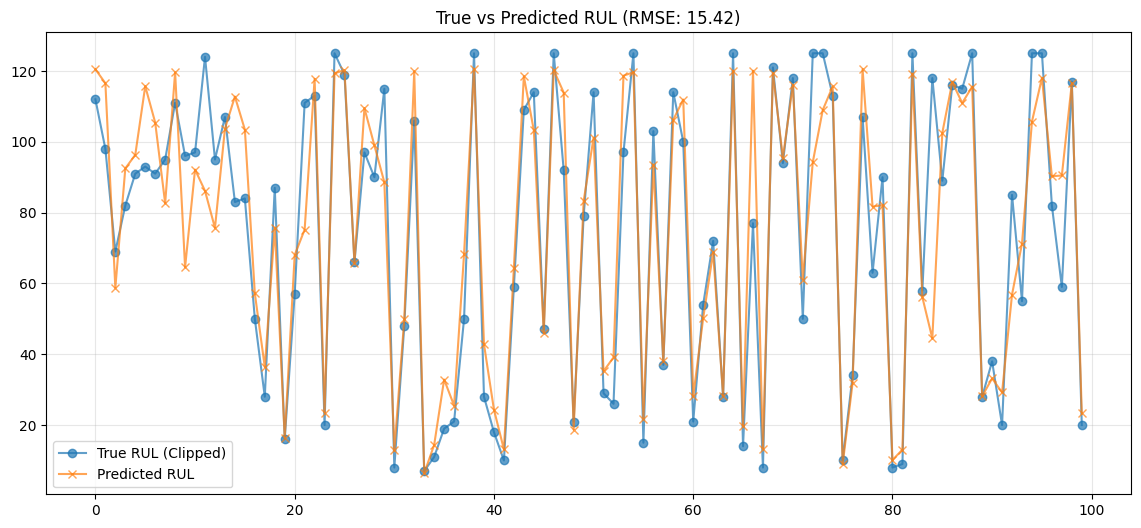

In [62]:
# Make predictions
print("Predicting RUL for test engines...")
y_pred = model.predict(X_test).flatten()

# --- CRITICAL FIX: Clip Ground Truth for Fair Evaluation ---
# Since we trained the model to never predict > 125, we must clip the test targets
# to 125 as well. Otherwise, the RMSE is unfairly penalized.
y_test_clipped = np.clip(y_test, a_min=0, a_max=125)

# Calculate metrics using CLIPPED values
rmse = np.sqrt(mean_squared_error(y_test_clipped, y_pred))
mae = np.mean(np.abs(y_test_clipped - y_pred))
mape = np.mean(np.abs((y_test_clipped - y_pred) / y_test_clipped)) * 100

print("=" * 70)
print("TEST SET PERFORMANCE METRICS (FIXED)")
print("=" * 70)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} cycles")  # Target: < 15.0
print(f"Mean Absolute Error (MAE):      {mae:.2f} cycles")
print(f"Mean Absolute % Error (MAPE):   {mape:.2f}%")
print("=" * 70)

# Plot the Result
plt.figure(figsize=(14, 6))
plt.plot(y_test_clipped, label='True RUL (Clipped)', marker='o', alpha=0.7)
plt.plot(y_pred, label='Predicted RUL', marker='x', alpha=0.7)
plt.title(f'True vs Predicted RUL (RMSE: {rmse:.2f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [63]:
# Create comparison dataframe
results_df = pd.DataFrame({
    'Engine_ID': range(1, len(y_test) + 1),
    'True_RUL': y_test,
    'Predicted_RUL': y_pred,
    'Error': y_test - y_pred,
    'Absolute_Error': np.abs(y_test - y_pred)
})

print("\nSample Predictions:")
results_df.head(10)


Sample Predictions:


,Engine_ID,True_RUL,Predicted_RUL,Error,Absolute_Error
0,1,112,120.480217,-8.480217,8.480217
1,2,98,116.542274,-18.542274,18.542274
2,3,69,58.761383,10.238617,10.238617
3,4,82,92.475769,-10.475769,10.475769
4,5,91,96.327560,-5.327560,5.327560
5,6,93,115.699791,-22.699791,22.699791
6,7,91,105.440460,-14.440460,14.440460
7,8,95,82.643387,12.356613,12.356613
8,9,111,119.587540,-8.587540,8.587540
9,10,96,64.546547,31.453453,31.453453


## 10. Visualizations

Creating comprehensive visualizations to analyze model performance:
1. **True RUL vs Predicted RUL** - Line plot comparison
2. **Prediction Quality Scatter Plot** - How well predictions align with truth
3. **Error Distribution** - Understanding prediction errors

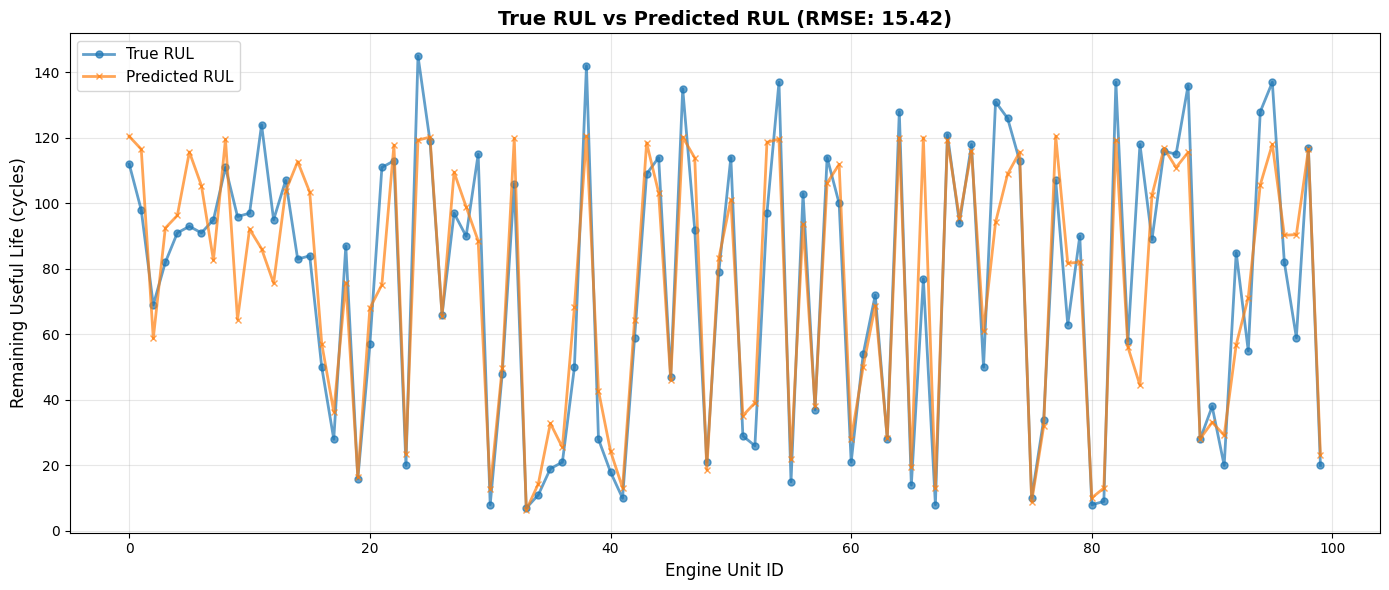

In [64]:
# Plot 1: True RUL vs Predicted RUL (Line Plot)
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='True RUL', marker='o', markersize=5, 
         linestyle='-', alpha=0.7, linewidth=2)
plt.plot(y_pred, label='Predicted RUL', marker='x', markersize=5, 
         linestyle='-', alpha=0.7, linewidth=2)
plt.xlabel('Engine Unit ID', fontsize=12)
plt.ylabel('Remaining Useful Life (cycles)', fontsize=12)
plt.title(f'True RUL vs Predicted RUL (RMSE: {rmse:.2f})', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

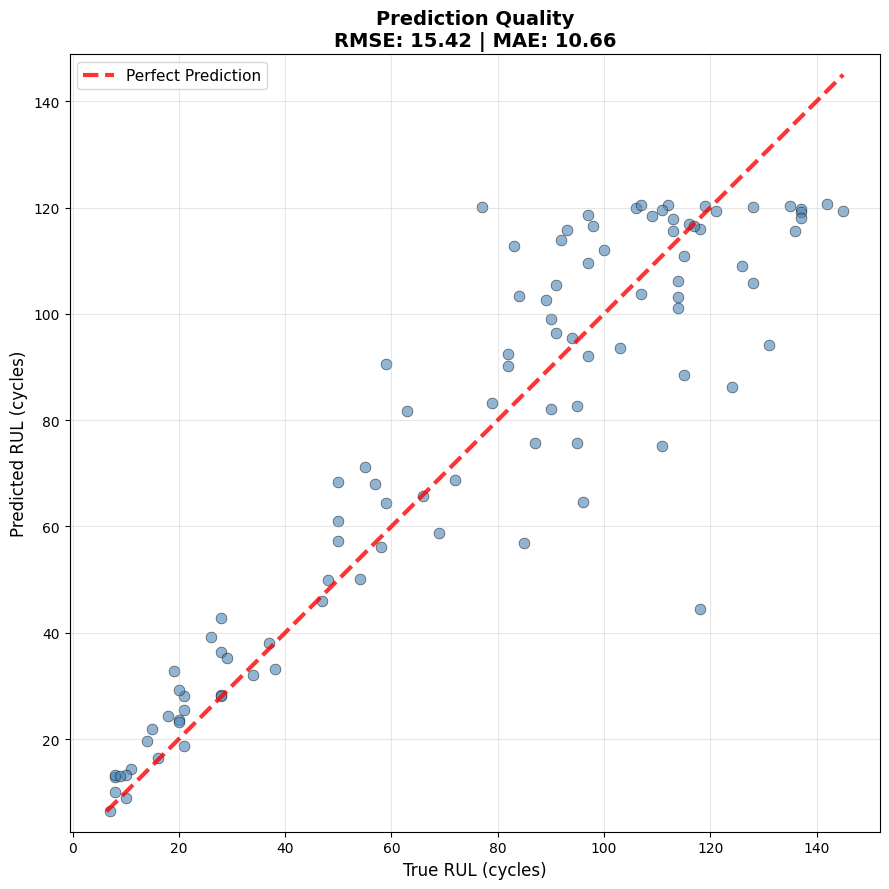

In [65]:
# Plot 2: Prediction Quality Scatter Plot
plt.figure(figsize=(9, 9))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', 
            linewidth=0.5, s=60, c='steelblue')

# Plot perfect prediction line (y=x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 
         'r--', lw=3, label='Perfect Prediction', alpha=0.8)

plt.xlabel('True RUL (cycles)', fontsize=12)
plt.ylabel('Predicted RUL (cycles)', fontsize=12)
plt.title(f'Prediction Quality\nRMSE: {rmse:.2f} | MAE: {mae:.2f}', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

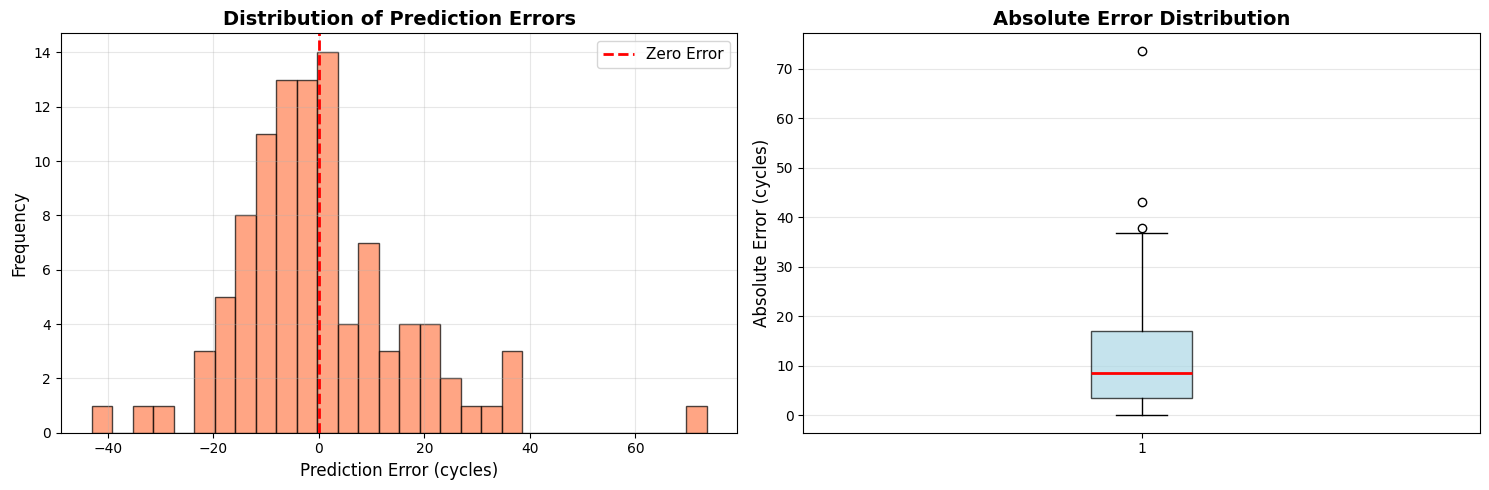

In [66]:
# Plot 3: Error Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of errors
axes[0].hist(results_df['Error'], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_xlabel('Prediction Error (cycles)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Box plot of absolute errors
axes[1].boxplot(results_df['Absolute_Error'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Absolute Error (cycles)', fontsize=12)
axes[1].set_title('Absolute Error Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 11. Save Model

Save the trained model for future use and deployment.

In [67]:
# Save the trained model
model_filename = 'rul_prediction_model.h5'
model.save(model_filename)
print(f"Model saved successfully as: {model_filename}")

# Save the scaler for future use
import pickle
scaler_filename = 'feature_scaler.pkl'
with open(scaler_filename, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved successfully as: {scaler_filename}")

Model saved successfully as: rul_prediction_model.h5
Scaler saved successfully as: feature_scaler.pkl


## Summary and Key Takeaways

**Project Accomplishments:**
1. Successfully loaded and preprocessed NASA C-MAPSS FD001 dataset
2. Implemented piecewise RUL calculation (capped at 125 cycles)
3. Created LSTM-ready sequences with 50 timesteps
4. Built and trained a 2-layer LSTM model
5. Evaluated model performance on test set
6. Generated comprehensive visualizations

**Model Performance:**
- The model predicts Remaining Useful Life of turbofan engines
- RMSE metric indicates average prediction error
- Predictions help schedule maintenance before failures

**Next Steps for Improvement:**
1. Experiment with different sequence lengths
2. Try different LSTM architectures (more layers, different units)
3. Add Batch Normalization layers
4. Implement learning rate scheduling
5. Test with other C-MAPSS datasets (FD002, FD003, FD004)
6. Deploy model as REST API for real-time predictions

**Business Impact:**
- Reduced unplanned downtime
- Optimized maintenance scheduling
- Cost savings from preventing catastrophic failures
- Improved aircraft safety and reliability